Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.preprocessing import normalize
from scipy.special import expit as sigmoid
import sklearn.metrics as metrics

Data loading and preprocessing

In [2]:
csv_path = "/home/jens/masterRepo/test/dataset/analysis_of_tp_and_fp_5.000000_5.000000.csv"
df = pd.read_csv(csv_path, dtype = {"objName":"category"})
df["visibleInlierFrac"] = df["visibleInliers"]/df["visiblePoints"]
df["visiblePointsFrac"] = df["visiblePoints"]/df["objectPoints"]
df["penetration"] = df[["penetrationInternal","penetrationExternal"]].max(axis=1)
df["intersectingInliers"] = df[["intersectingInliersInternal","intersectingInliersExternal"]].max(axis=1)
df["inCollision"] = df[["inCollisionInternal","inCollisionExternal"]].max(axis=1)
df["intersectingInliersFrac"] = df["intersectingInliers"] / df["visibleInliers"]
df["intersectingInliersInternalFrac"] = df["intersectingInliersInternal"] / df["visibleInliers"]
df["intersectingInliersExternalFrac"] = df["intersectingInliersExternal"] / df["visibleInliers"]
df[["visibleInlierFrac","visiblePointsFrac","penetration","intersectingInliers","inCollision","intersectingInliersFrac","intersectingInliersInternalFrac","intersectingInliersExternalFrac"]]=df[["visibleInlierFrac","visiblePointsFrac","penetration","intersectingInliers","inCollision","intersectingInliersFrac","intersectingInliersInternalFrac","intersectingInliersExternalFrac"]].fillna(0)


df.head()

,objName,dpI,gI,g,score,visiblePoints,visibleInliers,inCollisionInternal,inCollisionExternal,penetrationInternal,...,intersectingInliersExternal,objectPoints,visibleInlierFrac,visiblePointsFrac,penetration,intersectingInliers,inCollision,intersectingInliersFrac,intersectingInliersInternalFrac,intersectingInliersExternalFrac
0,AngleTubes,0,0,1,56.9764,1668,1317,0,0,0.0,...,0,5051,0.789568,0.330232,0.000000,0,0,0.000000,0.000000,0.0
1,AngleTubes,0,1,1,55.1934,1728,1256,1,0,0.0,...,0,5051,0.726852,0.342110,0.125520,1,1,0.000796,0.000796,0.0
2,AngleTubes,0,2,1,53.7115,1754,1220,0,0,0.0,...,0,5051,0.695553,0.347258,0.000000,0,0,0.000000,0.000000,0.0
3,AngleTubes,0,3,1,51.1050,1769,1275,1,0,0.0,...,0,5051,0.720746,0.350228,0.572053,0,1,0.000000,0.000000,0.0
4,AngleTubes,0,4,1,49.9980,1601,1177,1,0,0.0,...,0,5051,0.735166,0.316967,0.661725,0,1,0.000000,0.000000,0.0


In [3]:
df.groupby(["objName","g"]).mean()[["score","inCollision","inCollisionInternal","intersectingInliers","intersectingInliersInternal"]]


score  inCollision  inCollisionInternal  \
objName    g                                                
AngleTubes 0  29.128259     0.597156             0.289100   
           1  39.806362     0.527221             0.363897   
Conrods    0  15.842540     0.886275             0.749020   
           1  26.514218     0.684444             0.386667   
Ears       0  13.935260     0.679803             0.586207   
           1  20.116707     0.436620             0.098592   
Gameboys   0  23.160628     0.699187             0.585366   
           1  40.203082     0.455882             0.058824   

              intersectingInliers  intersectingInliersInternal  
objName    g                                                    
AngleTubes 0            16.663507                     5.729858  
           1             6.905444                     0.057307  
Conrods    0            22.756863                    11.274510  
           1            14.373333                     0.057778  
Ears       0            67.527094                    62.591133  
           1            16.042254                     0.549296  
Gameboys   0           101.186992                    83.943089  
           1            38.514706                     0.411765

In [57]:

def makeList(obj):
    if type(obj) is not list:
        obj = [obj]
    return obj
def get_data_for_logistic_regression(df,objects,factors,normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    obj_df = df[df["objName"].isin(objects)]
    X = obj_df[factors].values
    if len(X.shape)==1:
        X = np.expand_dims(X,axis=1)
    if normalize_factors:
        X = normalize(X,axis=0,norm="max")

    y = np.expand_dims(obj_df.g.values,axis=1)

    return X, y

def binary_logistic_regession_individual_factors(df,objects = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"factor":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for obj in objects:
        for factor in factors:
            X,y = get_data_for_logistic_regression(df,obj,factor,normalize_factors)
            model = LogisticRegressionCV(solver='lbfgs', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
            result_dict["objName"].append(obj)
            result_dict["factor"].append(factor)
            result_dict["accuracy"].append(classification_report["accuracy"])
            result_dict["precision"].append(classification_report["1"]["precision"])
            result_dict["recall"].append(classification_report["1"]["recall"])
            result_dict["f1"].append(classification_report["1"]["f1-score"])
            result_dict["n_posetives"].append(classification_report["1"]["support"])
            result_dict["n_negatives"].append(classification_report["0"]["support"])
    
    result_df = pd.DataFrame(result_dict)

    return models, result_df

def binary_logistic_regession(df,objects = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for factor in factors:
        result_dict[factor+"_w"]=[]
    result_dict["intercept"]=[]

    for obj in objects:
        X,y = get_data_for_logistic_regression(df,obj,factors,normalize_factors)
        model = LogisticRegressionCV(solver='lbfgs', random_state=42).fit(X, y)
        models[obj] = model
        classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
        result_dict["objName"].append(obj)
        result_dict["accuracy"].append(classification_report["accuracy"])
        result_dict["precision"].append(classification_report["1"]["precision"])
        result_dict["recall"].append(classification_report["1"]["recall"])
        result_dict["f1"].append(classification_report["1"]["f1-score"])
        result_dict["n_posetives"].append(classification_report["1"]["support"])
        result_dict["n_negatives"].append(classification_report["0"]["support"])
        for factor,coef in zip(factors,model.coef_[0]):
            result_dict[factor+"_w"].append(coef)
        result_dict["intercept"].append(model.intercept_[0])

    result_df = pd.DataFrame(result_dict)

    return models, result_df

def binary_logistic_regession_all(df,objects = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for factor in factors:
        result_dict[factor+"_w"]=[]
    result_dict["intercept"]=[]


    X,y = get_data_for_logistic_regression(df,objects,factors,normalize_factors)
    model = LogisticRegressionCV(solver='lbfgs', random_state=42).fit(X, y)
    classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
    result_dict["objName"].append("all")
    result_dict["accuracy"].append(classification_report["accuracy"])
    result_dict["precision"].append(classification_report["1"]["precision"])
    result_dict["recall"].append(classification_report["1"]["recall"])
    result_dict["f1"].append(classification_report["1"]["f1-score"])
    result_dict["n_posetives"].append(classification_report["1"]["support"])
    result_dict["n_negatives"].append(classification_report["0"]["support"])
    for factor,coef in zip(factors,model.coef_[0]):
        result_dict[factor+"_w"].append(coef)
    result_dict["intercept"].append(model.intercept_[0])

    result_df = pd.DataFrame(result_dict)

    return model, result_df



def logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    models = {}
    fig, axes = plt.subplots(n_factors,n_objects,figsize=(n_objects*5,n_factors*5))
    for ax_row,factor in zip(axes,factors):
        for ax, obj in zip(ax_row,object_names):
            obj_df = df[df["objName"]==obj]
            X = np.expand_dims(obj_df[factor].values,axis=1)
            if(normalize_factors):
                X = normalize(X,axis=0,norm="max")

            y = np.expand_dims(obj_df.g.values,axis=1)
            model = LogisticRegressionCV(solver='lbfgs', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            y_pred = model.predict(X)

            cm =  metrics.confusion_matrix(y,y_pred)
            X_transformed = X.dot(model.coef_.T) + model.intercept_

            sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
            sigmoid_y = sigmoid(sigmoid_x).ravel()
            ax.plot(sigmoid_x, sigmoid_y.ravel(), color='red', linewidth=3)
            ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

            ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
            ax.set_ylabel("$\sigma$")
            ax.set_xlabel(factor)
            ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

def logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac","penetrationInternal","intersectingInliersFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    fig, axes = plt.subplots(1,n_objects,figsize=(n_objects*5,5))
    fig.suptitle("Linear Combination of: {}".format(factors), fontsize=16)
    for ax, obj in zip(axes,object_names):
        obj_df = df[df["objName"]==obj]
        X = obj_df[factors].values
        if(normalize_factors):
            X = normalize(X,axis=0,norm="max")

        y = np.expand_dims(obj_df.g.values,axis=1)
        model = LogisticRegressionCV(solver='lbfgs', random_state=0).fit(X, y)
        y_pred = model.predict(X)

        cm =  metrics.confusion_matrix(y,y_pred)
        X_transformed = X.dot(model.coef_.T) + model.intercept_

        sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
        sigmoid_y = sigmoid(sigmoid_x).ravel()
        ax.plot(sigmoid_x, sigmoid_y, color='red', linewidth=3)
        ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

        ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
        ax.set_ylabel("$\sigma$")
        # ax.legend(["Decision Function","Decision threshold"])
        ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

def print_tuning_params(result_df,variables):
    for index,row in result_df.iterrows():
        for v in variables:
            print(row["objName"],"LR",v+"_w",row[v+"_w"],sep=",")
        print(row["objName"],"LR","intercept",row["intercept"],sep=",")     

## Logistic Regression on Individual Pr Object factors

In [19]:
variables = ["score","visibleInlierFrac","visiblePointsFrac"]
models, result_df = binary_logistic_regession_individual_factors(df,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df.head()

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

,objName,factor,accuracy,precision,recall,f1,n_posetives,n_negatives
0,AngleTubes,score,0.737500,0.747549,0.873926,0.805812,349,211
1,AngleTubes,visibleInlierFrac,0.732143,0.746898,0.862464,0.800532,349,211
2,AngleTubes,visiblePointsFrac,0.707143,0.703297,0.916905,0.796020,349,211
3,Ears,score,0.777372,0.692308,0.253521,0.371134,71,203
4,Ears,visibleInlierFrac,0.817518,0.684211,0.549296,0.609375,71,203


/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

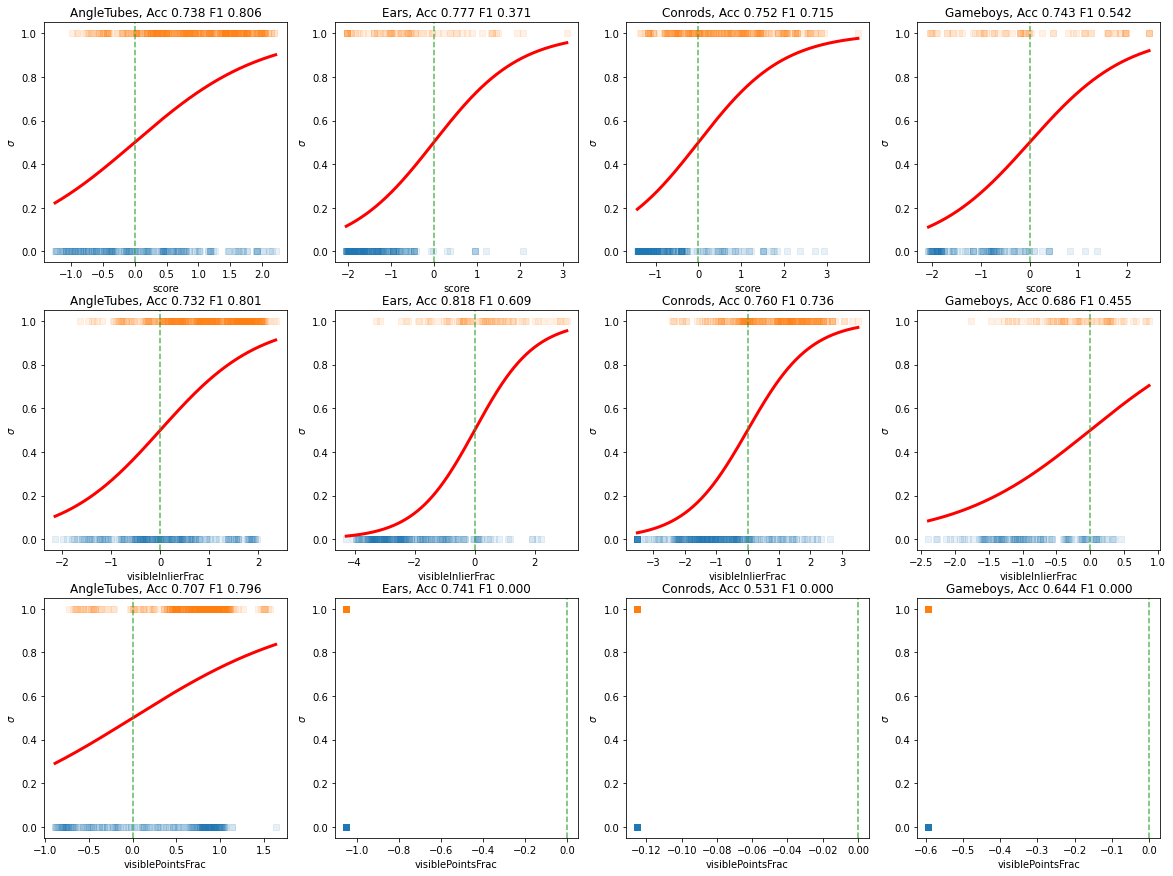

In [20]:
logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["score","visibleInlierFrac","visiblePointsFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionIndividual.pdf")
plt.savefig("PrObjectLogisticRegressionIndividual.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors

In [21]:
models, result_df = binary_logistic_regession(df,["AngleTubes","Ears","Conrods","Gameboys"],["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,intercept
0,AngleTubes,0.748214,0.775132,0.839542,0.806052,349,211,0.047869,10.627059,3.875117,-6.744336
1,Ears,0.824818,0.682540,0.605634,0.641791,71,203,0.052659,9.264332,6.478528,-10.316521
2,Conrods,0.770833,0.777778,0.715556,0.745370,225,255,0.102931,-0.349850,4.521276,-3.487740
3,Gameboys,0.774869,0.755102,0.544118,0.632479,68,123,0.055464,6.420135,3.667649,-7.852332


In [22]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.047868639527274645
AngleTubes,LR,visibleInlierFrac_w,3.8751166366554726
AngleTubes,LR,visiblePointsFrac_w,10.627058768859019
AngleTubes,LR,intercept,-6.744335815322443
Ears,LR,score_w,0.05265914287760419
Ears,LR,visibleInlierFrac_w,6.478528497044209
Ears,LR,visiblePointsFrac_w,9.264332256005236
Ears,LR,intercept,-10.316520511225855
Conrods,LR,score_w,0.10293142138058119
Conrods,LR,visibleInlierFrac_w,4.521276415592231
Conrods,LR,visiblePointsFrac_w,-0.3498496509599513
Conrods,LR,intercept,-3.4877403004560374
Gameboys,LR,score_w,0.05546442638242799
Gameboys,LR,visibleInlierFrac_w,3.6676487249064524
Gameboys,LR,visiblePointsFrac_w,6.420134693700283
Gameboys,LR,intercept,-7.852332337114151


/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

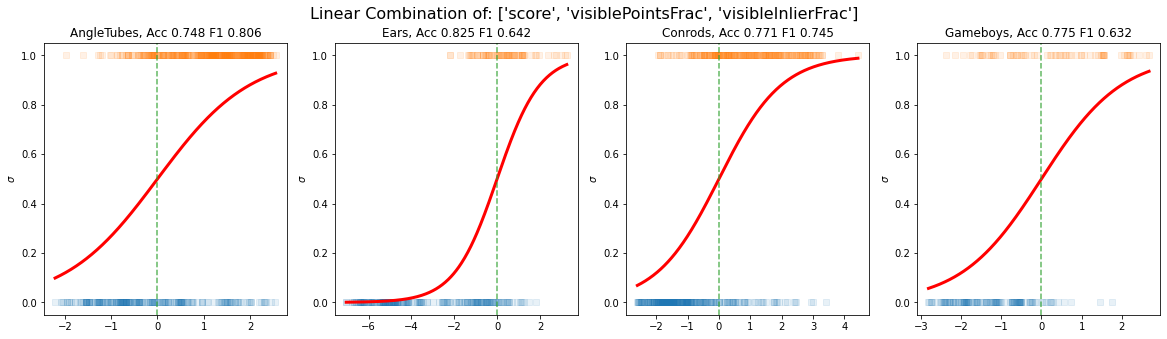

In [23]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegression.pdf")
plt.savefig("PrObjectLogisticRegression.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors and Global factors

In [59]:
variables = ["score","visibleInlierFrac","intersectingInliersFrac"]
models, result_df = binary_logistic_regession_all(df,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visibleInlierFrac_w,intersectingInliersFrac_w,intercept
0,all,0.742193,0.726639,0.730715,0.728671,713,792,0.044764,3.384924,-10.18755,-2.387217


In [80]:
model = models
c = model.coef_
X = df[["score","visibleInlierFrac","intersectingInliersFrac"]].values
print(X.shape,c.shape)
z = np.matmul(c, X.T)
print(np.min(z),np.max(z))

(1505, 3) (1, 3)
-2.964750597047421 5.977773578269057


In [50]:
variables = ["score","visibleInlierFrac","intersectingInliersFrac"]
models, result_df = binary_logistic_regession_all(df,["AngleTubes","Conrods","Gameboys"],variables,normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visibleInlierFrac_w,intersectingInliersFrac_w,intercept
0,all,0.731925,0.730088,0.771028,0.75,642,589,0.056367,2.099529,-9.661101,-2.175469


In [51]:
variables = ["score","visibleInlierFrac","intersectingInliersFrac"]
models, result_df = binary_logistic_regession_all(df,["AngleTubes","Ears","Gameboys"],variables,normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visibleInlierFrac_w,intersectingInliersFrac_w,intercept
0,all,0.748293,0.719466,0.772541,0.745059,488,537,0.032385,4.896768,-11.650137,-3.119121


In [52]:
variables = ["score","visibleInlierFrac","intersectingInliersFrac"]
models, result_df = binary_logistic_regession_all(df,["AngleTubes","Ears","Conrods"],variables,normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visibleInlierFrac_w,intersectingInliersFrac_w,intercept
0,all,0.729833,0.745763,0.682171,0.712551,645,669,0.089156,0.012405,-0.007609,-2.319527


In [33]:
result_df[[s+"_w" for s in variables]+["intercept"]].mean()

score_w                      0.070157
visibleInlierFrac_w          5.019059
intersectingInliersFrac_w   -8.383380
intercept                   -3.389726
dtype: float64

In [26]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.04816486731976851
AngleTubes,LR,visiblePointsFrac_w,18.00779036040455
AngleTubes,LR,visibleInlierFrac_w,2.6742071833938326
AngleTubes,LR,intersectingInliersFrac_w,-18.134136246848534
AngleTubes,LR,intercept,-8.26648351657747
Ears,LR,score_w,0.0880677249658336
Ears,LR,visiblePointsFrac_w,9.436573123387351
Ears,LR,visibleInlierFrac_w,8.139208327144221
Ears,LR,intersectingInliersFrac_w,-21.88596786311262
Ears,LR,intercept,-10.509938582948866
Conrods,LR,score_w,0.08811524582313603
Conrods,LR,visiblePointsFrac_w,-2.167939570756431
Conrods,LR,visibleInlierFrac_w,6.931626880679095
Conrods,LR,intersectingInliersFrac_w,-10.896174027172904
Conrods,LR,intercept,-2.6682102893737363
Gameboys,LR,score_w,0.06204885446356385
Gameboys,LR,visiblePointsFrac_w,0.6632871311119163
Gameboys,LR,visibleInlierFrac_w,1.891048684262548
Gameboys,LR,intersectingInliersFrac_w,-3.749745620040855
Gameboys,LR,intercept,-3.614468435312011


/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

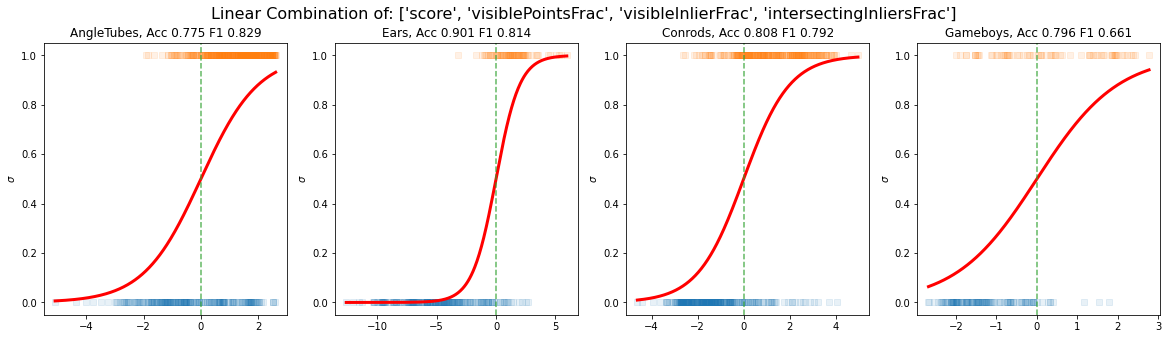

In [27]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= variables,normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.pdf")
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.png")
plt.show()

In [28]:
df_m = df
df_m["intersectingInliersFracSelective"] =  (df["g"]*df["inCollisionInternal"]*df["intersectingInliersInternalFrac"]) + ((1-df["g"])*df["inCollisionExternal"]*df["intersectingInliersExternalFrac"]) 
df_m["penetrationSelective"] =  (df["g"]*df["inCollisionInternal"]*df["penetrationInternal"]) + ((1-df["g"])*df["inCollisionExternal"]*df["penetrationExternal"]) 

variables = ["score","visiblePointsFrac","visibleInlierFrac","penetrationSelective","intersectingInliersFracSelective"]
models, result_df = binary_logistic_regession(df_m,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,penetrationSelective_w,intersectingInliersFracSelective_w,intercept
0,AngleTubes,0.782143,0.793282,0.879656,0.834239,349,211,0.041037,15.598098,3.057020,0.719470,-29.938946,-7.554638
1,Ears,0.839416,0.714286,0.633803,0.671642,71,203,0.051589,7.148220,6.290562,-3.165533,-3.836659,-8.599284
2,Conrods,0.841667,0.817021,0.853333,0.834783,225,255,0.066549,-0.369923,7.553883,-0.063534,-59.776194,-3.255004
3,Gameboys,0.806283,0.816327,0.588235,0.683761,68,123,0.053437,4.200594,3.743023,-1.249788,-6.396454,-6.388445


In [29]:
df_m_coll = df[df["penetration"]>1]
df_m_coll["intersectingInliersFracSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["intersectingInliersInternalFrac"]) + ((1-df_m_coll["g"])*df_m_coll["inCollisionExternal"]*df_m_coll["intersectingInliersExternalFrac"]) 
df_m_coll["penetrationSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["penetrationInternal"]) + ((1-df_m_coll["g"])*df_m_coll["inCollisionExternal"]*df_m_coll["penetrationExternal"]) 

variables = ["score","visiblePointsFrac","visibleInlierFrac","penetrationSelective","intersectingInliersFracSelective"]
models, result_df = binary_logistic_regession(df_m_coll,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df

<ipython-input-29-80fa68d1fb9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m_coll["intersectingInliersFracSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["intersectingInliersInternalFrac"]) + ((1-df_m_coll["g"])*df_m_coll["inCollisionExternal"]*df_m_coll["intersectingInliersExternalFrac"])
<ipython-input-29-80fa68d1fb9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m_coll["penetrationSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["penetrat

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,penetrationSelective_w,intersectingInliersFracSelective_w,intercept
0,AngleTubes,0.833333,0.828571,0.906250,0.865672,32,22,0.072674,4.823599,2.387188,-0.252866,-4.435694,-4.801037
1,Ears,0.967742,1.000000,0.666667,0.800000,3,28,0.156376,0.009010,0.011051,-0.066350,-0.000802,-5.087039
2,Conrods,0.882353,0.836735,0.773585,0.803922,53,117,0.130127,1.409663,6.036675,0.003847,-8.745571,-5.877743
3,Gameboys,0.883721,1.000000,0.375000,0.545455,8,35,0.084746,-0.000344,0.003509,0.000715,-0.000756,-4.172395


In [30]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.07267438719089933
AngleTubes,LR,visiblePointsFrac_w,4.823599359465266
AngleTubes,LR,visibleInlierFrac_w,2.3871882748938313
AngleTubes,LR,penetrationSelective_w,-0.2528656068679905
AngleTubes,LR,intersectingInliersFracSelective_w,-4.435693633631627
AngleTubes,LR,intercept,-4.8010373250090135
Ears,LR,score_w,0.15637629898921743
Ears,LR,visiblePointsFrac_w,0.009010437351482128
Ears,LR,visibleInlierFrac_w,0.011051255120017778
Ears,LR,penetrationSelective_w,-0.06634984681545063
Ears,LR,intersectingInliersFracSelective_w,-0.0008016667682016834
Ears,LR,intercept,-5.0870392307550585
Conrods,LR,score_w,0.13012715227459404
Conrods,LR,visiblePointsFrac_w,1.4096631272164868
Conrods,LR,visibleInlierFrac_w,6.036675045430986
Conrods,LR,penetrationSelective_w,0.003847354286770691
Conrods,LR,intersectingInliersFracSelective_w,-8.745570863080136
Conrods,LR,intercept,-5.877743300161659
Gameboys,LR,score_w,0.0847455015375666
Gameboys,LR,visiblePointsFrac_w,-0.00034439515651992907
G